**try using MOFA2 for dimensionality reduction first**

In [28]:
library(data.table)
library(MOFA2)
library(reshape2)
library(ggplot2)

# read metadata
meta <- read.csv("../data/metadatav2.txt", sep = '\t', row.names=1)
meta$tbClass <- trimws(meta$tbClass, which = "right")
meta <- subset(meta, tbClass %in% c("Confirmed", "Unlikely"))


meta <- meta[meta$savio_id != "", ]
meta$sample <- sub("_R.*\\.fastq\\.gz$", "", meta$savio_id)
# read humann pathway abundances 
pathabundance <- read.table(
  '../data/pathabundance_all.tsv',
  sep = '\t', # tab-delimited
  row.names = 1, # first column is row names
  check.names = FALSE, # current sample names are not R-safe, this tells R to not change them
  header = TRUE,  # first row is a header
  comment.char = '', # ignore the top line (starts with #)
   quote='' # ignore quotes
)
colnames(pathabundance) <- sub("_Abundance$", "", colnames(pathabundance))
## check intersection of samples between humann and metadata

shared_samples <- intersect(colnames(pathabundance), meta$sample)
rownames(meta) <- meta$sample
meta <- meta[shared_samples, ]
pathabundance <- pathabundance[, shared_samples]
# remove unmapped and unintegrated rows
pathabundance <- pathabundance[!rownames(pathabundance) %in% c("UNMAPPED", "UNINTEGRATED"), ]
pathabundance <- pathabundance[!grepl("UNINTEGRATED", rownames(pathabundance)), ]
pathabundance <- pathabundance[!grepl("unclassified", rownames(pathabundance)), ]

## pull out cross-taxa and by-taxa pathway abundances ( you could keep these together, but I like to separate them)
cross_taxa <- pathabundance[!grepl("\\|", rownames(pathabundance)),]
by_taxa <- pathabundance[grepl("\\|", rownames(pathabundance)),]

## filter out rows (pathways) with 0 counts
by_taxa <- by_taxa[rowSums(by_taxa) != 0, ]
cross_taxa <- cross_taxa[rowSums(cross_taxa) != 0, ]
## filter out rows found in less than 20% of samples
prevcut <- 0.2
cross_taxa <- cross_taxa[rowSums(cross_taxa == 0) <= prevcut * ncol(cross_taxa), ]
by_taxa <- by_taxa[rowSums(by_taxa == 0) <= prevcut * ncol(by_taxa), ]

# Normalize with CLR
cross_taxa <- cross_taxa + 1
cross_taxa <- log(cross_taxa) - matrix(colMeans(log(cross_taxa)), nrow = nrow(cross_taxa), ncol = ncol(cross_taxa), byrow = TRUE)
by_taxa <- by_taxa + 1
by_taxa <- log(by_taxa) - matrix(colMeans(log(by_taxa)), nrow = nrow(by_taxa), ncol = ncol(by_taxa), byrow = TRUE)

Warning message in matrix(colMeans(log(by_taxa)), nrow = nrow(by_taxa), ncol = ncol(by_taxa), :
"non-empty data for zero-extent matrix"


Looks like just no species-specific pathways are showing up in >20% of samples

In [29]:
dim(by_taxa)

[1]    0 6561

In [30]:
dim(cross_taxa)

[1] 271  81

**create a long-format table**

In [31]:
melted_cross_taxa <- melt(as.matrix(cross_taxa), varnames = c("feature", "sample"), value.name = "value")
melted_cross_taxa$view <- "pathway"
head(melted_cross_taxa)

,feature,sample,value,view
,<fct>,<fct>,<dbl>,<chr>
1,1CMET2-PWY: folate transformations III (E. coli),LIB003300_22C2NCLT3_S21_L003,1.2808956,pathway
2,ANAEROFRUCAT-PWY: homolactic fermentation,LIB003300_22C2NCLT3_S21_L003,1.0915697,pathway
3,ANAGLYCOLYSIS-PWY: glycolysis III (from glucose),LIB003300_22C2NCLT3_S21_L003,1.7602292,pathway
4,ARG+POLYAMINE-SYN: superpathway of arginine and polyamine biosynthesis,LIB003300_22C2NCLT3_S21_L003,-1.2359760,pathway
5,ARGININE-SYN4-PWY: L-ornithine biosynthesis II,LIB003300_22C2NCLT3_S21_L003,-0.7566427,pathway
6,ARGSYN-PWY: L-arginine biosynthesis I (via L-ornithine),LIB003300_22C2NCLT3_S21_L003,1.3453113,pathway


**fit the MOFA object**

In [32]:
mofa_pathway <- create_mofa(melted_cross_taxa)
model_opts <- get_default_model_options(mofa_pathway)
model_opts$num_factors <- 10
mofa_pathway <- prepare_mofa(mofa_pathway, model_options = model_opts)
mofa_pathway <- run_mofa(mofa_pathway, use_basilisk = TRUE)

samples_metadata(mofa_pathway) <- meta


Creating MOFA object from a data.frame...

Checking data options...

No data options specified, using default...

No training options specified, using default...

Checking model options...

Warning message in run_mofa(mofa_pathway, use_basilisk = TRUE):
"No output filename provided. Using /var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T//Rtmp5bIPsV/mofa_20250925-074924.hdf5 to store the trained model.

"
Connecting to the mofapy2 package using basilisk. 
    Set 'use_basilisk' to FALSE if you prefer to manually set the python binary using 'reticulate'.



[[1]]

[[2]]


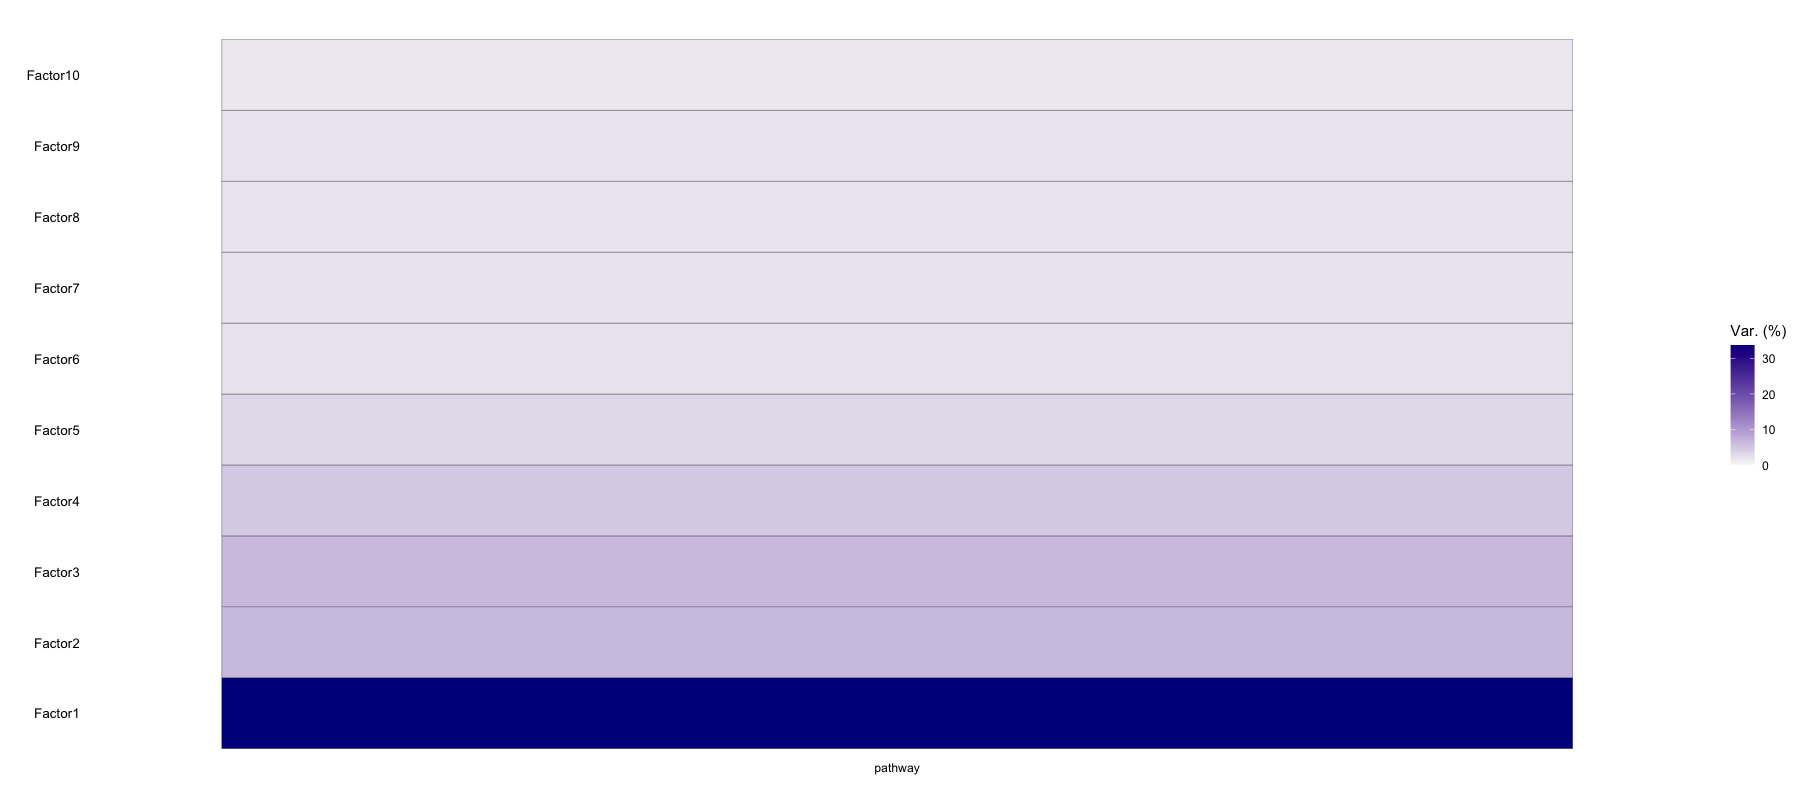

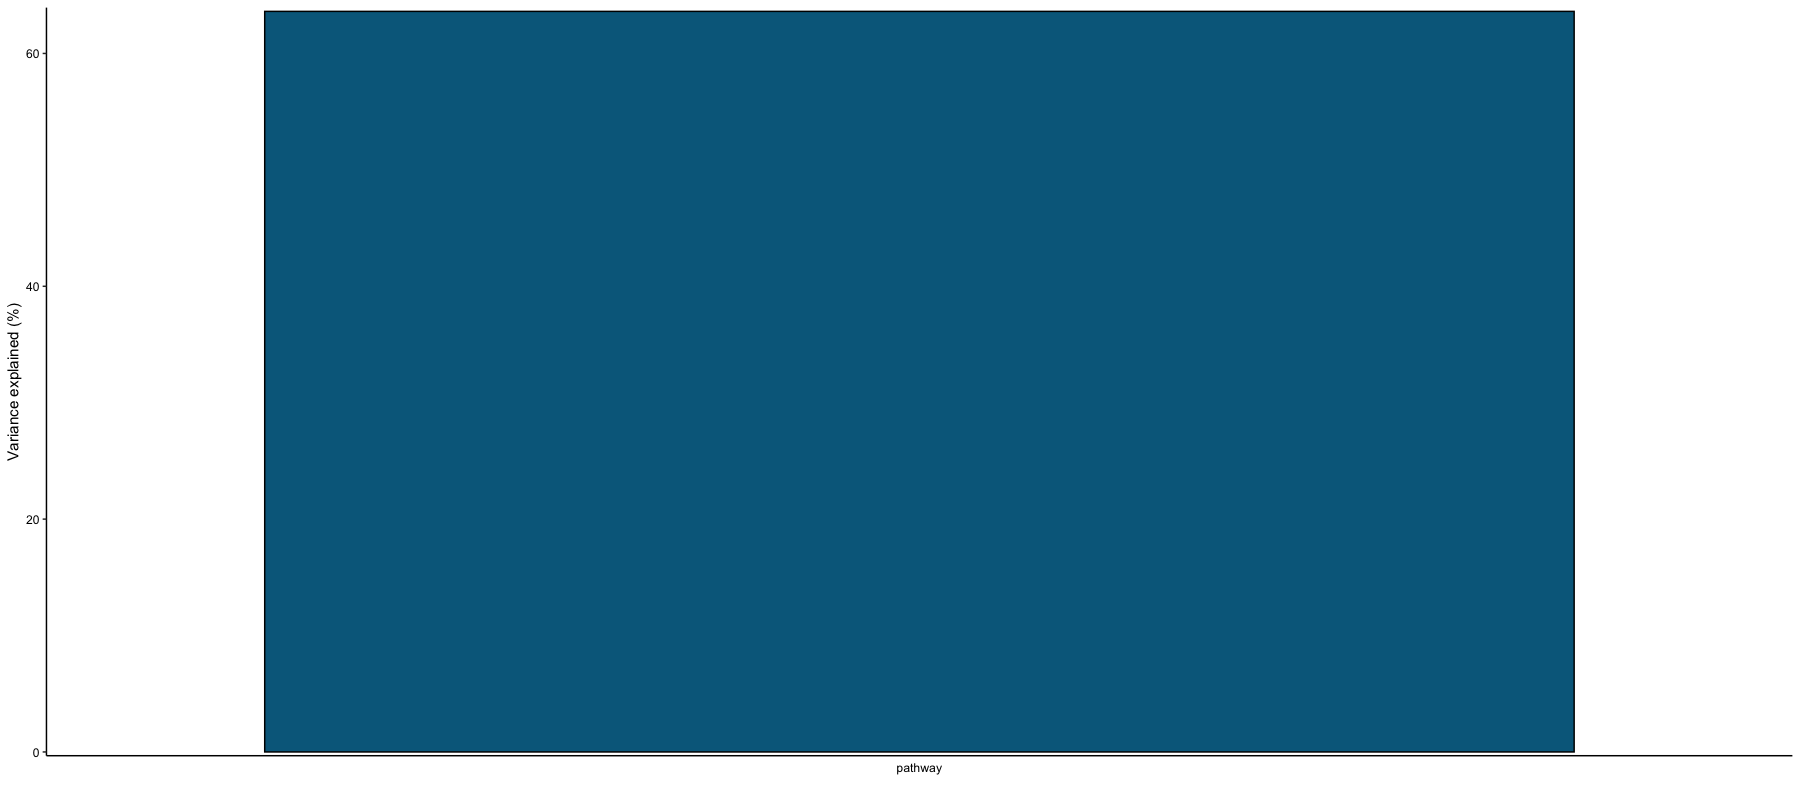

In [33]:
plot_variance_explained(mofa_pathway, plot_total ='T')

Warning message in correlate_factors_with_covariates(mofa_pathway, covariates = c("tbClass", :
"There are non-numeric values in the covariates data.frame, converting to numeric..."


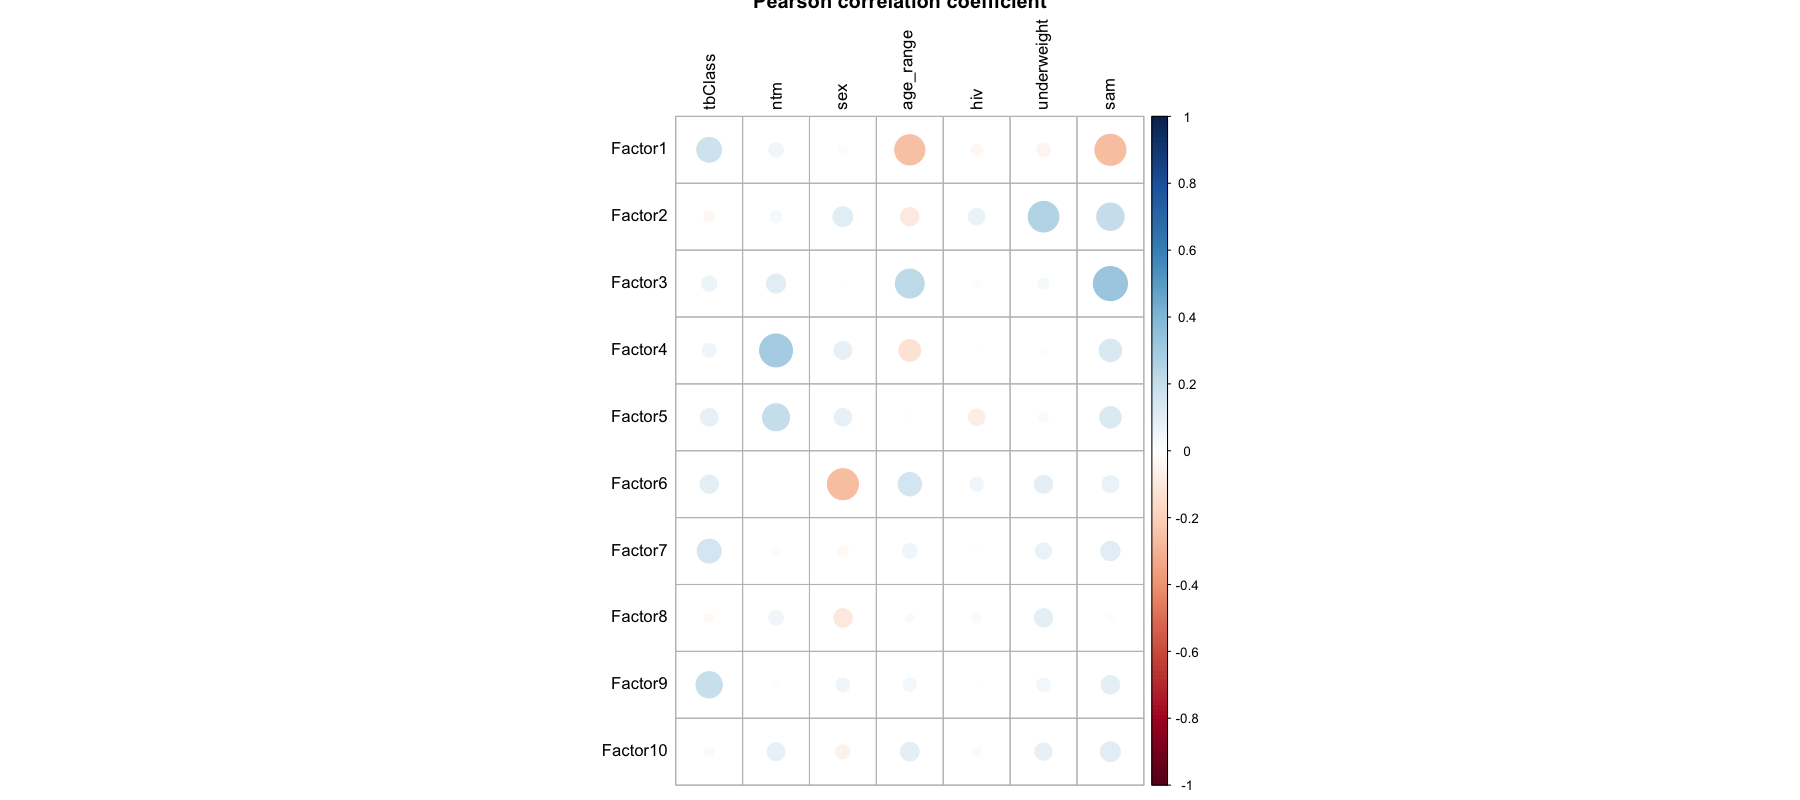

In [34]:
correlate_factors_with_covariates(mofa_pathway, 
  covariates = c('tbClass', 'ntm','sex', 'age_range', 'hiv', 'underweight', 'sam'),
  plot = "r"  # use "log_pval" to plot log p-values 
)

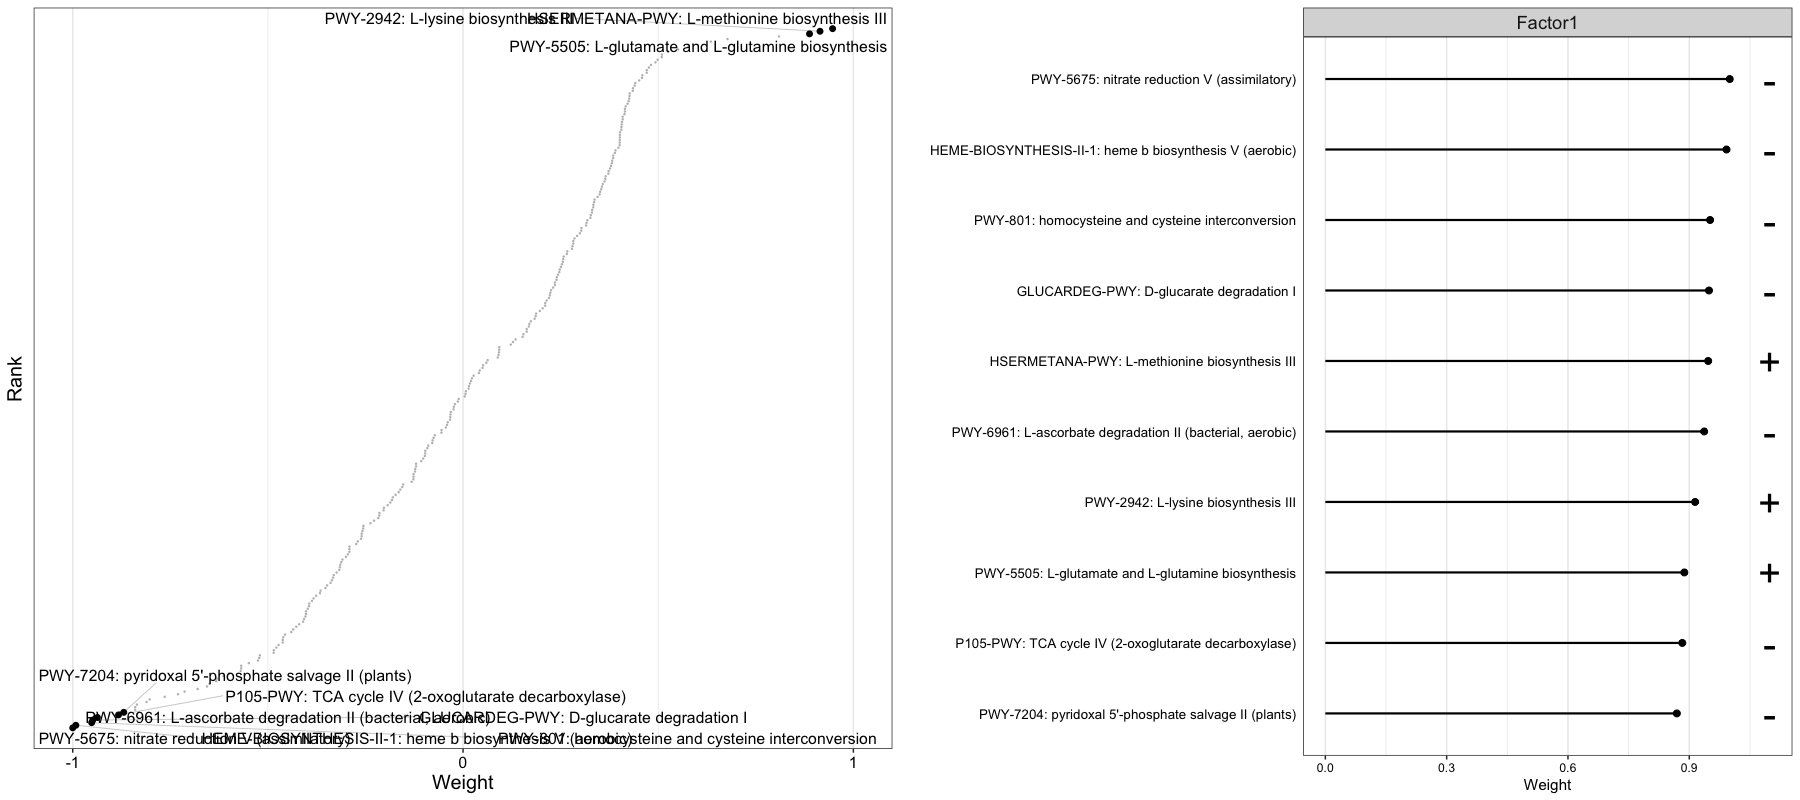

In [35]:
plot_weights_fn <- function(mofa_obj, factor=1, view=1, nfeatures=10) {
  p1 <- plot_weights(mofa_obj, 
    factors = factor, 
    view = view,
    nfeatures = nfeatures,
    text_size = 4
  ) 
  
  p2 <- plot_top_weights(mofa_obj, 
    factors = factor, 
    view = view,
    nfeatures = nfeatures
  ) 
  
  p <- cowplot::plot_grid(plotlist=list(p1,p2), nrow=1, rel_widths = c(1.5, 1.5))
  return(p)
}
options(repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 100)
plot_weights_fn(mofa_pathway, factor=1,view='pathway', nfeatures=10)

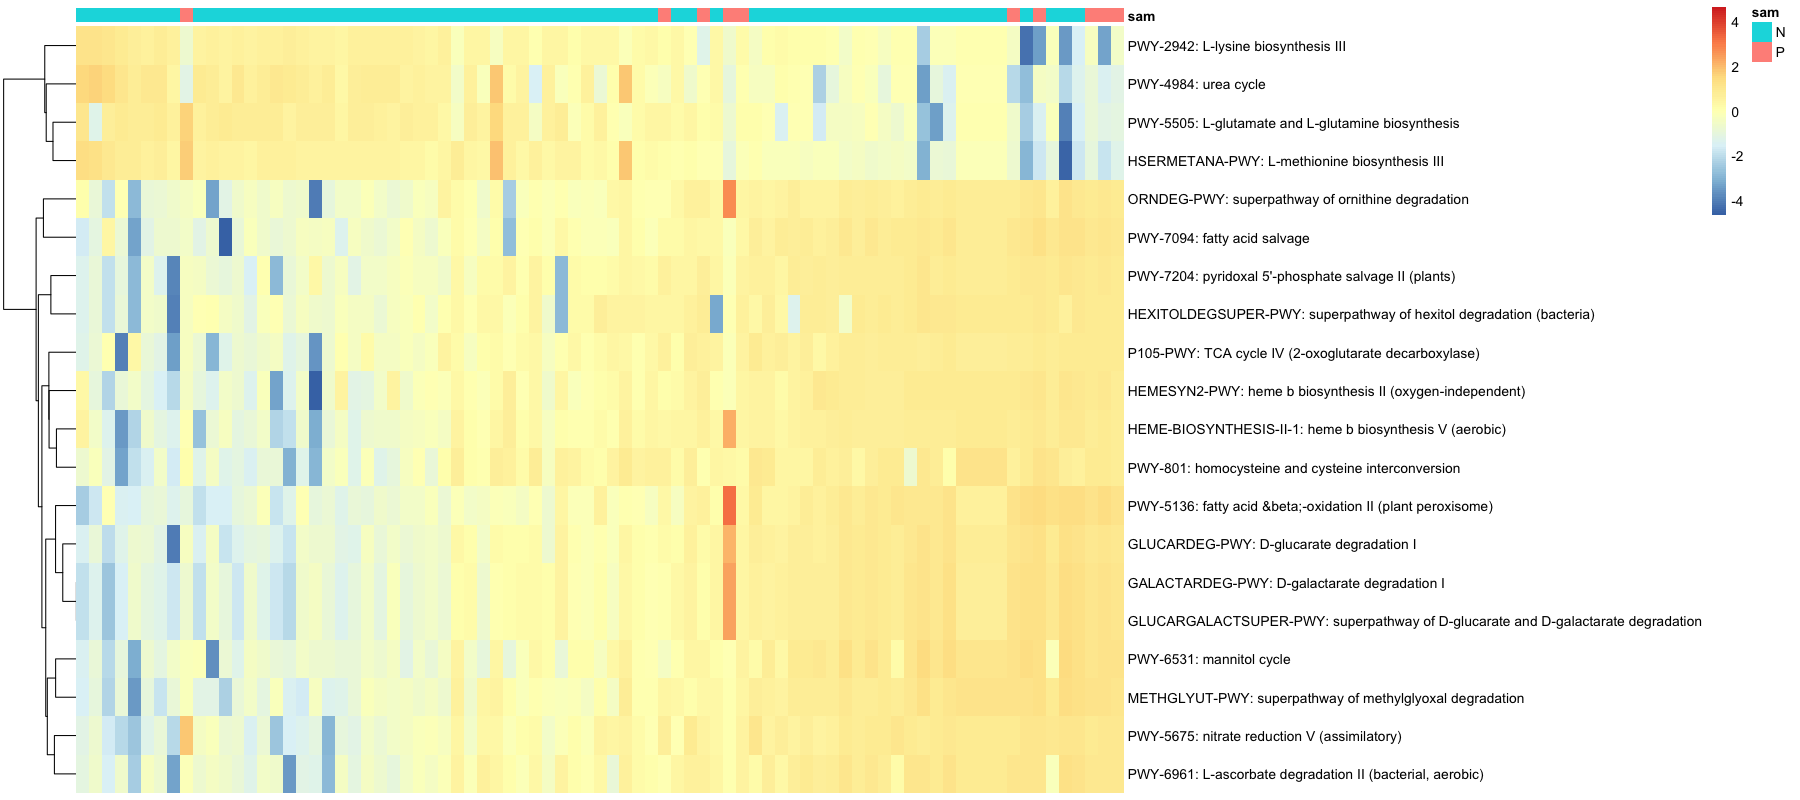

In [38]:
plot_data_heatmap(mofa_pathway, 
  factor = 1, 
  view = "pathway", 
  features = 20,
  denoise = FALSE,
  cluster_rows = T, cluster_cols = F,
  show_colnames = F, show_rownames = T,
  annotation_samples = "sam",   
  annotation_legend = T,
  scale = "row"
)